In [9]:
import argparse
import multiprocessing as mp
import numpy as np
import os
import tempfile
import time
import cv2
import matplotlib.pyplot as plt

from detectron2.config import get_cfg
from detectron2.data.detection_utils import read_image
from detectron2.utils.logger import setup_logger
import sys
sys.path.append('./')
sys.path.append('../')
from config import add_cutler_config
from predictor import VisualizationDemo

In [10]:
def setup_cfg(args):
    # load config from file and command-line arguments
    cfg = get_cfg()
    add_cutler_config(cfg)
    # To use demo for Panoptic-DeepLab, please uncomment the following two lines.
    # from detectron2.projects.panoptic_deeplab import add_panoptic_deeplab_config  # noqa
    # add_panoptic_deeplab_config(cfg)
    cfg.merge_from_file(args.config_file)
    cfg.merge_from_list(args.opts)
    # Disable the use of SyncBN normalization when running on a CPU
    # SyncBN is not supported on CPU and can cause errors, so we switch to BN instead
    if cfg.MODEL.DEVICE == 'cpu' and cfg.MODEL.RESNETS.NORM == 'SyncBN':
        cfg.MODEL.RESNETS.NORM = "BN"
        cfg.MODEL.FPN.NORM = "BN"
    # Set score_threshold for builtin models
    cfg.MODEL.RETINANET.SCORE_THRESH_TEST = args.confidence_threshold
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = args.confidence_threshold
    cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = args.confidence_threshold
    cfg.freeze()
    return cfg

In [11]:
def get_parser(inputs):
    parser = argparse.ArgumentParser(description="Detectron2 demo for builtin configs")
    parser.add_argument(
        "--config-file",
        default="configs/quick_schedules/mask_rcnn_R_50_FPN_inference_acc_test.yaml",
        metavar="FILE",
        help="path to config file",
    )
    parser.add_argument("--webcam", action="store_true", help="Take inputs from webcam.")
    parser.add_argument("--video-input", help="Path to video file.")
    parser.add_argument(
        "--input", help="path to the input image",
    )
    parser.add_argument(
        "--output",
        help="A file or directory to save output visualizations. "
        "If not given, will show output in an OpenCV window.",
    )
    parser.add_argument(
        "--confidence-threshold",
        type=float,
        default=0.35,
        help="Minimum score for instance predictions to be shown",
    )
    parser.add_argument(
        "--opts",
        help="Modify config options using the command-line 'KEY VALUE' pairs",
        default=[],
        nargs=argparse.REMAINDER,
    )
    args = parser.parse_args(inputs)
    return args

In [12]:
# !wget http://dl.fbaipublicfiles.com/cutler/checkpoints/cutler_cascade_final.pth

In [13]:
# provide arguments for running CutLER demo.

# Note: Using ***CPU*** by default. to run on GPU, remove "MODEL.DEVICE", "cpu".
# Note: please specify a path with "--input" if you want to try your own images.
# Note: you can use a lower --confidence-threshold to get a higher recall.
mp.set_start_method("spawn", force=True)
inputs = ['--config-file', "../model_zoo/configs/CutLER-ImageNet/cascade_mask_rcnn_R_50_FPN_demo.yaml", '--input', "/home/allysakate/Pictures/ch01_20230529161510_01.png", '--confidence-threshold', '0.5', "--opts", "MODEL.WEIGHTS", "cutler_cascade_final.pth", "MODEL.DEVICE", "cuda:0"]
args = get_parser(inputs)

In [14]:
setup_logger(name="fvcore")
logger = setup_logger()
logger.info("Arguments: " + str(args))
cfg = setup_cfg(args)
demo = VisualizationDemo(cfg)

[10/06 14:47:22 detectron2]: Arguments: Namespace(confidence_threshold=0.5, config_file='../model_zoo/configs/CutLER-ImageNet/cascade_mask_rcnn_R_50_FPN_demo.yaml', input='/home/allysakate/Pictures/ch01_20230529161510_01.png', opts=['MODEL.WEIGHTS', 'cutler_cascade_final.pth', 'MODEL.DEVICE', 'cuda:0'], output=None, video_input=None, webcam=False)
[10/06 14:47:24 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from cutler_cascade_final.pth ...
[10/06 14:47:24 fvcore.common.checkpoint]: [Checkpointer] Loading from cutler_cascade_final.pth ...


In [15]:
# use PIL, to be consistent with evaluation
img = read_image(args.input, format="BGR")
start_time = time.time()
predictions, visualized_output = demo.run_on_image(img)
logger.info(
    "{}: {} in {:.2f}s".format(
        args.input,
        "detected {} instances".format(len(predictions["instances"]))
        if "instances" in predictions
        else "finished",
        time.time() - start_time,
    )
)

# save image to your local directory
if args.output:
    if os.path.isdir(args.output):
        assert os.path.isdir(args.output), args.output
        out_filename = os.path.join(args.output, os.path.basename(args.input))
    else:
        assert len(args.input) == 1, "Please specify a directory with args.output"
        out_filename = args.output
    visualized_output.save(out_filename)

[10/06 14:47:27 detectron2]: /home/allysakate/Pictures/ch01_20230529161510_01.png: detected 11 instances in 1.23s


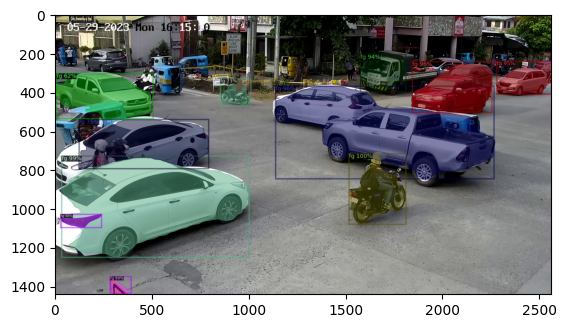

In [16]:
plt.imshow(visualized_output.get_image())